<a href="https://colab.research.google.com/github/Mekaela/isa_machine_learning/blob/main/wine_assignment_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a script to train a regression model to predict the response variable "quality" given the available explanatory variables for the Wine Quality data set (https://archive.ics.uci.edu/dataset/186/wine+quality) that contains 4898 examples.

The output of the script should include two plots:

1. Actual vs predicted values of the response variable

2. Loss (y axis) vs epochs (x axis)

The 10 keywords to address are:  input size, output size, model, loss function, epoch, optimizer, forward pass, backward pass, gradient descent, predict.

In [ ]:
!pip install ucimlrepo

So we don't need to upload the dataset in colab each time, it is easier to install ucimlrepo and import it. The following code is provided at the provided url to import this dataset with python

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

We can see there are several features and one target: the quality. Let's change this table into a pandas dataframe and have a look at some sample values:

In [ ]:
import pandas as pd

# Combine features and target into a single DataFrame
df = pd.concat([wine_quality.data.features, wine_quality.data.targets], axis=1)
print(df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Next, I want to see if there are any correlations between quality and any of these variables. First let's visualise them, and then we can do some further statistical analysis

<Figure size 1500x500 with 0 Axes>

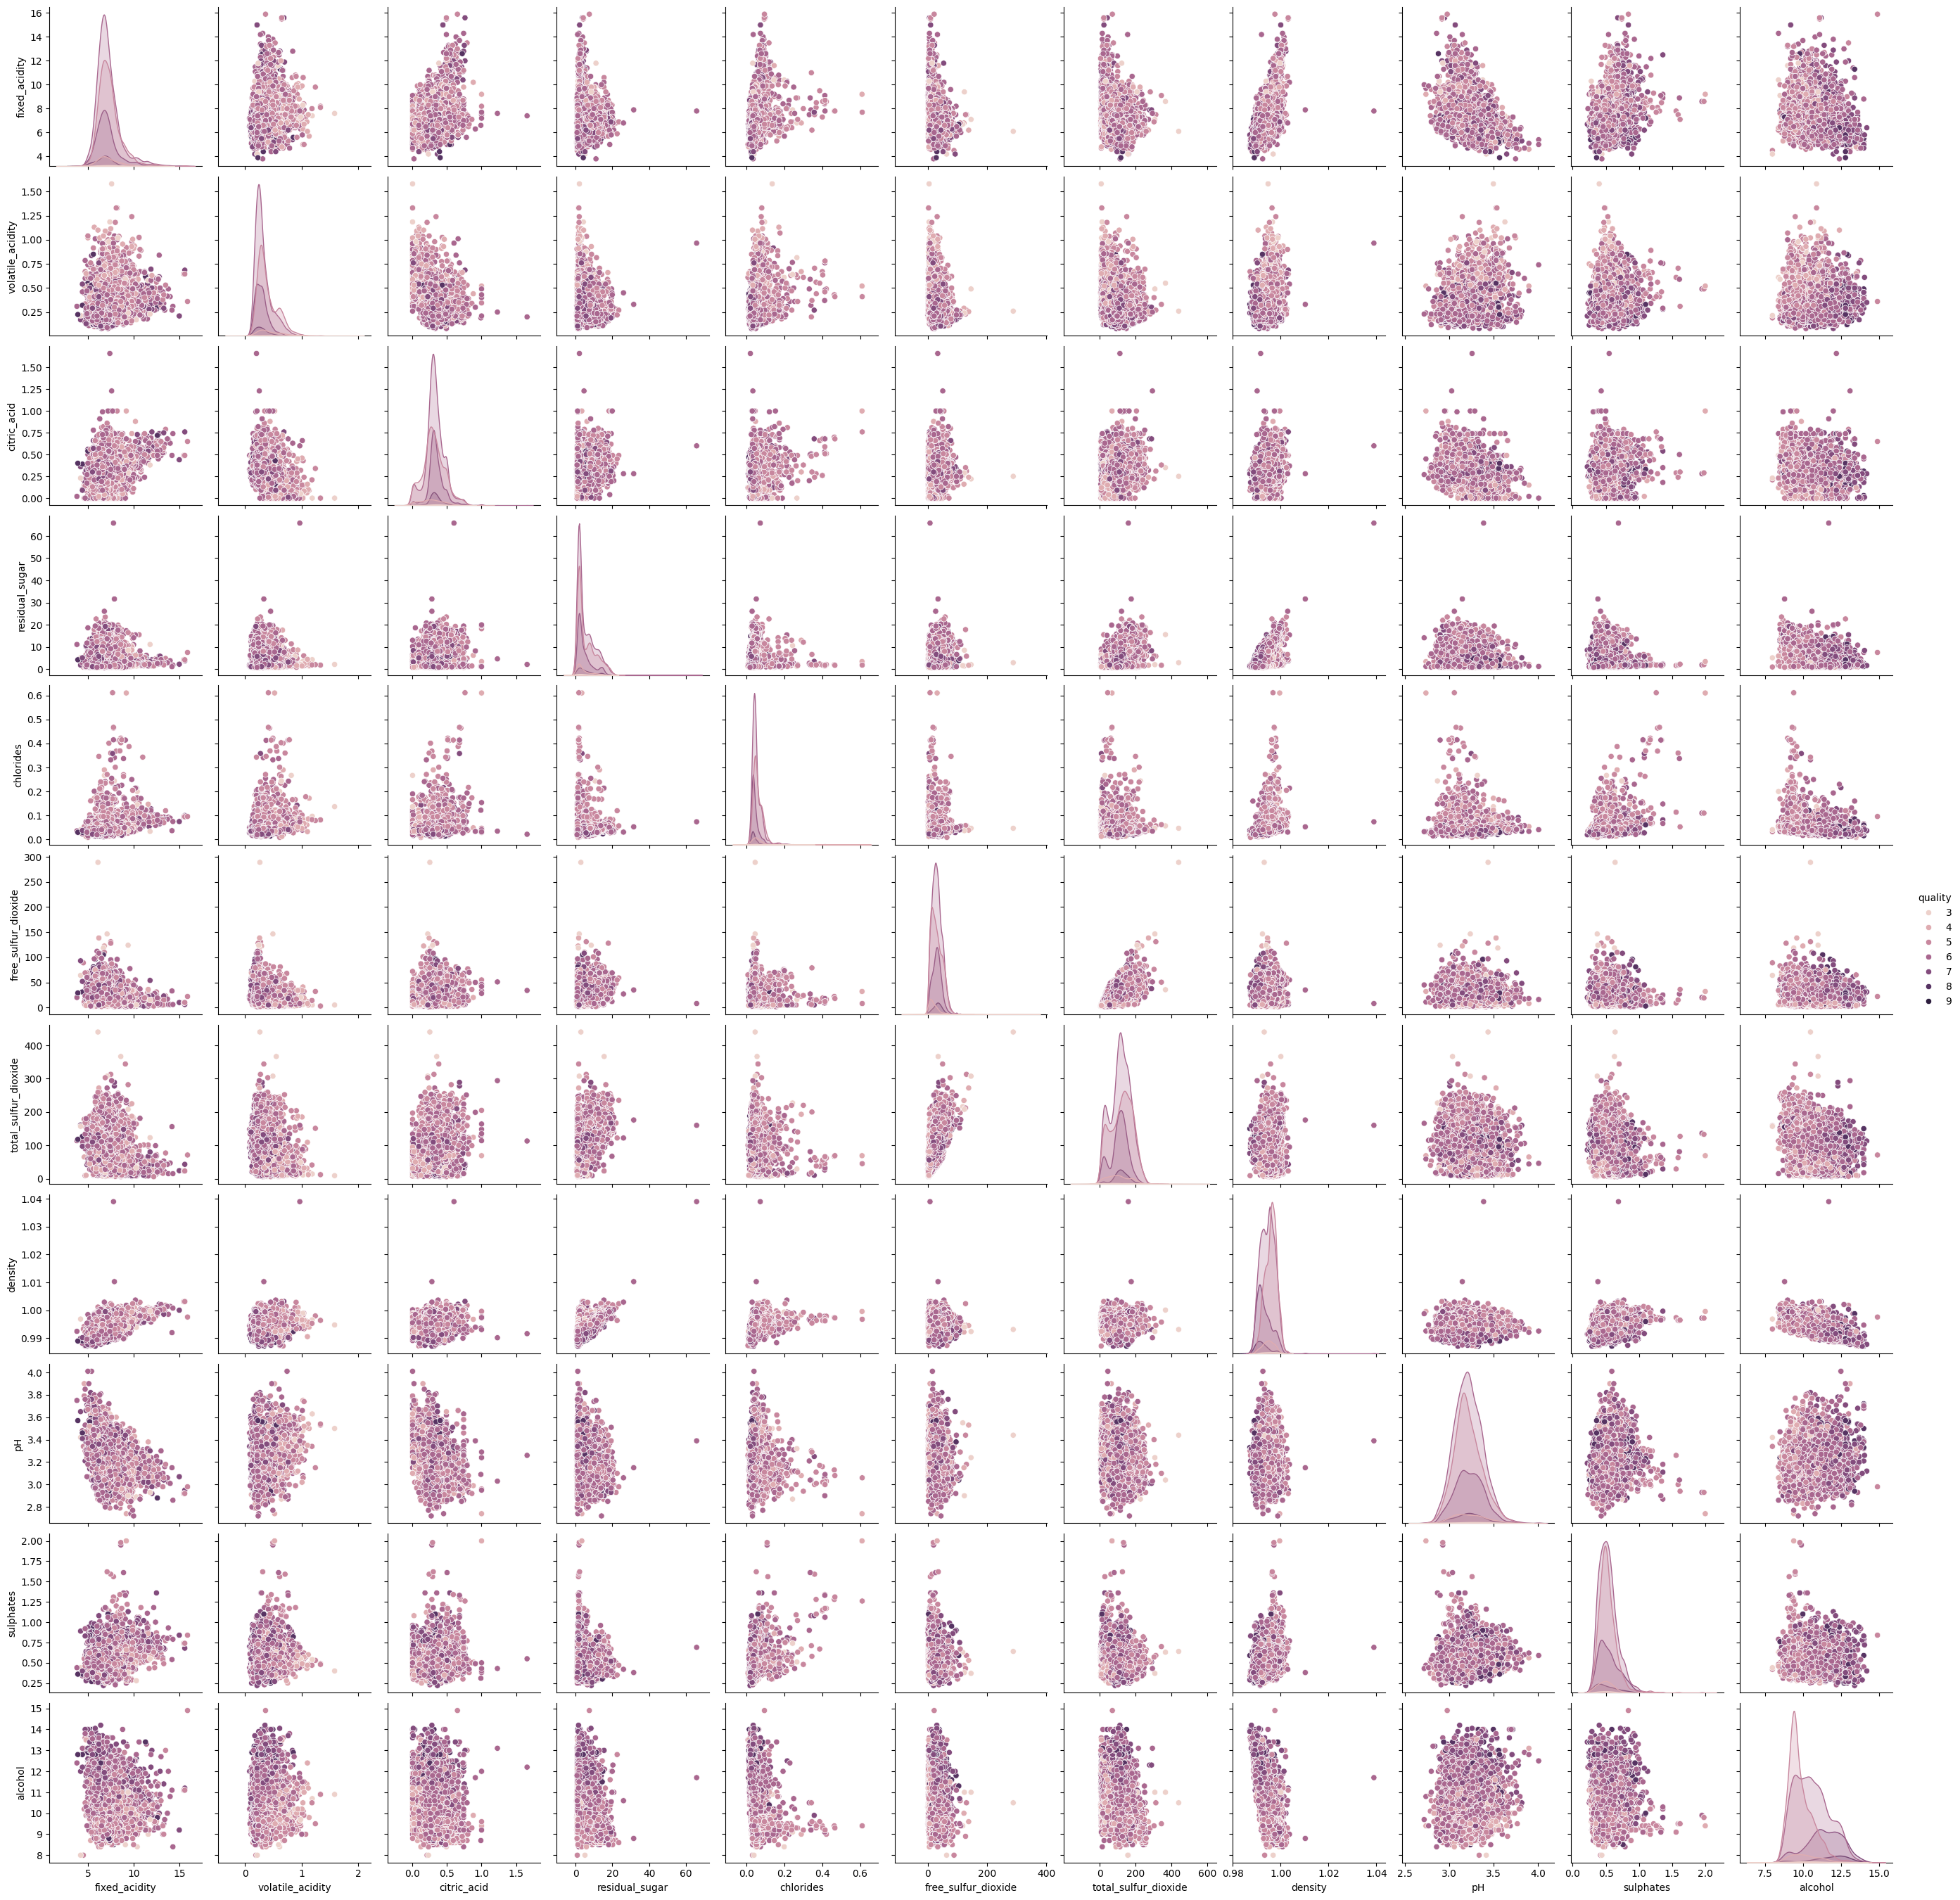

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.pairplot(df, hue='quality')
plt.show()

Not the best colour scheme, but we can see some seperation between dark and light between some variavles, for example volatile_acidity v alcohol looks darkerat the top and lighter at the bottom, but there is no clear seperation. Let's try a heat plot.

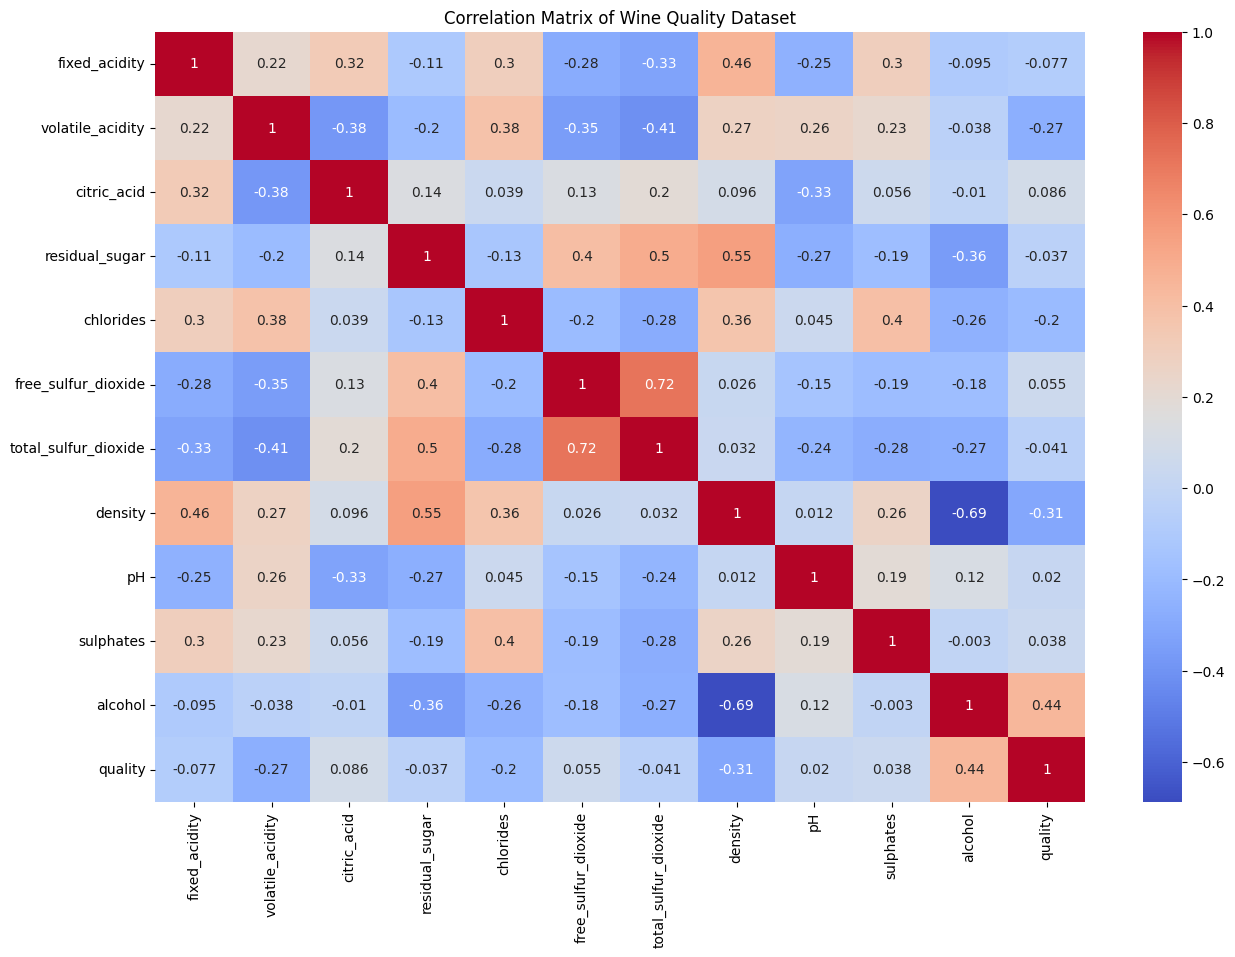

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Wine Quality Dataset')
plt.show()


Now we can see that volatile_acidity with alchohol has a very low correlation! More importantly, the strongest correlation is with alcohol (0.44), then density (-0.31), and volatile acidity (0.27).

Now that we have more of an understanding of the data, let's split the dataset into training and testing subsets and train the linear regression model:

Using pytorch

In [ ]:
print(X)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  

First we convert our data to pytorch tensors. Both X and y are one dimensional tensors.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Convert data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
print(X)

tensor([[ 7.4000,  0.7000,  0.0000,  ...,  3.5100,  0.5600,  9.4000],
        [ 7.8000,  0.8800,  0.0000,  ...,  3.2000,  0.6800,  9.8000],
        [ 7.8000,  0.7600,  0.0400,  ...,  3.2600,  0.6500,  9.8000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
        [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
        [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]])


X has all of the feature data in it, so it is 1 dimension with 11 values, and y is 1 dimension with one value. We can see this by printing each other their size. The first number printed is the number of rows, or items in the tensor, and the second value is the number of values in each row. This makes sense because we only have the quality variable in y, and all of the feature variables in X.

In [ ]:
print(X.size())
print(y.size())

torch.Size([6497, 11])
torch.Size([6497, 1])


Scale: Ensures that features contribute equally, as variables can be in different measurement units. StandardScaler uses the formula: z = (x - u) / s; for sample x, sample mean u, and standard deviation s.

One alternative is MinMaxScaler, which scales each feature such that the range is between a given range. e.g. 0ne and zero.

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

Train the dataset:

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

define the input size, output size, learning rate, and number of epochs
input size: size of the input tensor. The tensor that the prediction are based on (X_train in this case). This is 11, for our 11 features.
output_size: in our case we are predicting one value - the quality

In [ ]:
X_train.shape[1]

11

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
output_size = 1
learning_rate = 0.01
num_epochs = 100

Initialise the model. In this case Linear, which we're using because we want to perform multiple linear regression. This is because we're looking for the line of best fit for our data between our variables and what we're trying to predict - quality of wines.

Loss function: Calculates the gap between the prediction and the actual value (for quality in this case). The gradient of this loss is used in the loss function during back propogation. In this case Mean Square Error was chosen, which is one of the loss functions applied to regression problems. It is good at penalising outliers. Mean Absolute Error or Huber Loss could also have been used.

Optimizer: Updates the parameters to reduce the loss. Here we use SGD, which uses the same learning rate for each variable, as compared to Adam, which adapts the learning rate to each variable. Adam was much less efficient at reducing the loss for this problem.

In [ ]:
# Initialize the model, loss function, and optimizer
model = nn.Linear(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Training loop: forward and backward pass

Forward pass: compute loss

Back propogation: reverse of the chain rule, so finding derivative of z with respect to x. To find gradient. This gradient tells us how much the weight and bias should be adjusted

Loss: We want to minimise the loss. In this case we're using the mean squared error loss (seen above for variable 'criterion')

In [ ]:
# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 21.9268
Epoch [20/100], Loss: 14.8369
Epoch [30/100], Loss: 10.1053
Epoch [40/100], Loss: 6.9456
Epoch [50/100], Loss: 4.8344
Epoch [60/100], Loss: 3.4232
Epoch [70/100], Loss: 2.4792
Epoch [80/100], Loss: 1.8472
Epoch [90/100], Loss: 1.4238
Epoch [100/100], Loss: 1.1398


predictions

In [ ]:
# Make predictions on the test set
y_pred = model(X_test)

Finally plot:

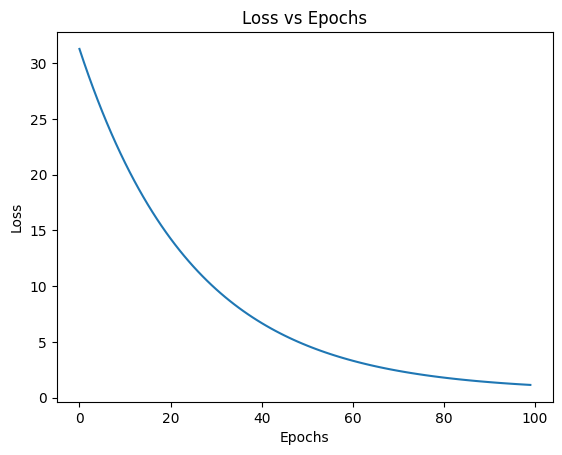

In [ ]:
# Plotting (requires matplotlib)
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

In [ ]:
plt.scatter(y_test, y_pred.detach().numpy())
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Quality")
plt.show()